In [1]:
import pycorr
# import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
from astropy import units as u
from astropy.io import fits
from sklearn.neighbors import KDTree
from data_process import jackknife_label
h = cosmos.H0.value/100

In [2]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
random = np.load('../catalogue/random_quasar_lss_all.npy')

In [22]:
npix = jackknife_label(quasar, 10)
npix_r = jackknife_label(random, 10)
pix = np.unique(npix)

In [3]:
with open('label.bin', 'rb') as f:
    npix = np.load(f)
    npix_r = np.load(f)
pix = np.unique(npix)

In [4]:
label = np.zeros_like(npix)
label_r = np.zeros_like(npix_r)
all_pix = np.unique(npix)
for i, p in enumerate(all_pix):
    label[npix==p] = i
    label_r[npix_r==p] = i

In [6]:
dis_cov_q = cosmos.comoving_distance(quasar['z']).to(u.Mpc).value*h
dis_cov_r = cosmos.comoving_distance(random['z']).to(u.Mpc).value*h

In [15]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

Nbins = 15
rp_min = 3
rp_max = 100

rp_bin_cross = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_cross = (rp_bin_cross[:-1]*rp_bin_cross[1:])**0.5

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin = 10**(np.arange(-5, Nbins+1)*sep + np.log10(rp_min))
# rp_bin_auto = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_auto = (rp_bin[:-1]*rp_bin[1:])**0.5

Nbins = len(rp_bin) - 1
pimax = 100

In [ ]:
pos_q = np.vstack([quasar['ra'], quasar['dec'], dis_cov_q])
pos_r = np.vstack([random['ra'], random['dec'], dis_cov_r])
correlation_func = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rp', rp_bin,
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar['w'],
    data_weights2=quasar['w'],
    data_samples1=label,
    data_samples2=label,
    randoms_samples1=label_r,
    randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)

In [ ]:
pos_q = np.vstack([quasar['ra'], quasar['dec'], dis_cov_q])
pos_r = np.vstack([random['ra'], random['dec'], dis_cov_r])
correlation_func = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rppi', (rp_bin, np.linspace(-pimax, pimax, 2*pimax+1, endpoint=True)),
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar['w'],
    data_weights2=quasar['w'],
    data_samples1=label,
    data_samples2=label,
    randoms_samples1=label_r,
    randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)

In [11]:
import pickle
with open('pycorr_1h_km.bin', 'rb') as f:
    correlation_func = pickle.load(f)
corr = correlation_func.get_corr(return_sep=True, return_cov=True)
rp, pi, xi, cov = corr
wp = xi.sum(axis=1)

In [12]:
stacked_cov = np.zeros((len(wp), len(wp)))
for i in range(len(wp)):
    for j in range(len(wp)):
        stacked_cov[i,j] = np.sum(cov[i*200:(i+1)*200, j*200:(j+1)*200])
std = np.sqrt([stacked_cov[i, i] for i in range(len(wp))])

In [22]:
cov_normed = stacked_cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))

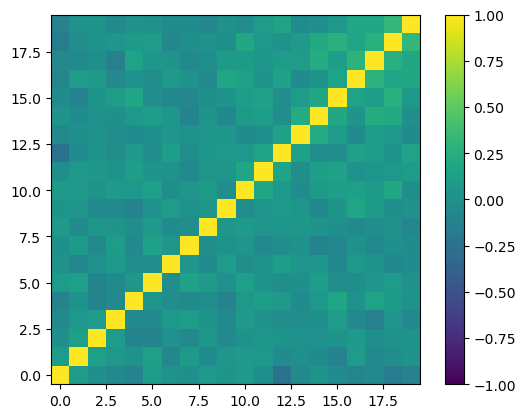

In [23]:
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

In [7]:
signal_path = '../mcmc/python/signal/'
def read_signal(file):
    ret_ls = []
    with open(file, 'rb') as f:
        while True:
            try: ret_ls.append(np.load(f, allow_pickle=True))
            except:
                break
    return ret_ls

def read_cov(file):
    cov = np.load(file)
    return cov

rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
cov = read_cov(signal_path + '/cov.npy')
std = np.sqrt([cov[i, i] for i in range(cov.shape[0])])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]

[]

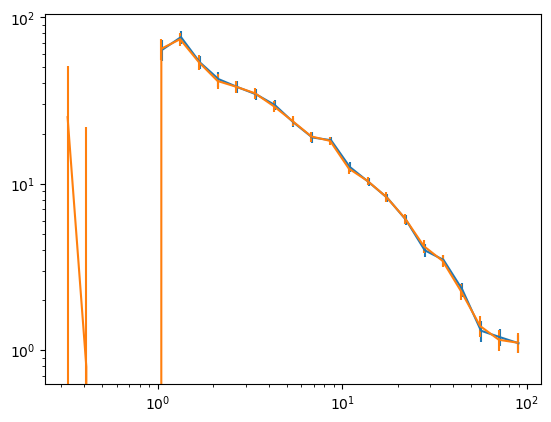

In [13]:
plt.errorbar(rp, wp, std)
plt.errorbar(rp_auto, signal_auto, err_auto)
plt.loglog()